In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [2]:
import yfinance as yf

In [3]:
#Download Tata motors data from yahoo finance
df = yf.download('BAJFINANCE.NS')

[*********************100%***********************]  1 of 1 completed


In [4]:
#first 5 samples
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-07-01,5.239737,5.540927,5.239737,5.412679,3.969702,21923
2002-07-02,5.523439,5.537041,5.421423,5.443769,3.992503,61044
2002-07-03,5.505950,5.545785,5.328151,5.466116,4.008893,34160
2002-07-04,5.501093,5.572018,5.417537,5.528297,4.054497,27892
2002-07-05,5.563274,5.656546,5.474860,5.590478,4.100100,58976


In [5]:
# to check dates in index
df.index

DatetimeIndex(['2002-07-01', '2002-07-02', '2002-07-03', '2002-07-04',
               '2002-07-05', '2002-07-08', '2002-07-09', '2002-07-10',
               '2002-07-11', '2002-07-12',
               ...
               '2023-06-15', '2023-06-16', '2023-06-19', '2023-06-20',
               '2023-06-21', '2023-06-22', '2023-06-23', '2023-06-26',
               '2023-06-27', '2023-06-30'],
              dtype='datetime64[ns]', name='Date', length=5216, freq=None)

In [6]:
df.shape

(5216, 6)

In [7]:
# to check features or columns 
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [8]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-22,7200.100098,7204.149902,7020.000000,7030.000000,6999.954102,827194
2023-06-23,7020.950195,7055.000000,6956.100098,6989.649902,6959.776367,815226
2023-06-26,6990.000000,7035.000000,6945.000000,6998.700195,6968.788086,563539
2023-06-27,7030.000000,7030.000000,6954.000000,7019.250000,6989.250000,709789
2023-06-30,7100.000000,7195.000000,7091.200195,7160.600098,7160.600098,887666


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5216 entries, 2002-07-01 to 2023-06-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5216 non-null   float64
 1   High       5216 non-null   float64
 2   Low        5216 non-null   float64
 3   Close      5216 non-null   float64
 4   Adj Close  5216 non-null   float64
 5   Volume     5216 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 285.2 KB


In [10]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

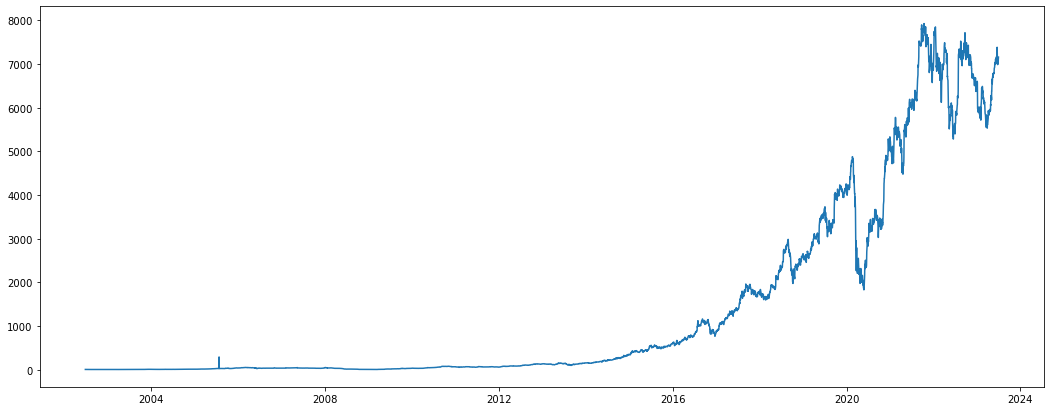

In [12]:
# plot a graph
plt1 = plt.figure(figsize=(18,7))
import matplotlib.pyplot as plt
plt.plot(df['Close'])

In [13]:
# check open price for first day and close price for last day
print("Starting price: ",df.iloc[0][0])
print("Ending price: ", df.iloc[-1][3])

Starting price:  5.239737033843994
Ending price:  7160.60009765625


In [14]:
# check start date and end date in our dataset
print("Starting date: ",df.index[0])
print("Ending date: ", df.index[-1])

Starting date:  2002-07-01 00:00:00
Ending date:  2023-06-30 00:00:00


In [15]:
# drop some columns except 'close ' columns as we are going to do prediction only on closing price
df.drop(columns=['High','Low','Adj Close','Volume'],inplace=True)

In [16]:
df.head()

,Open,Close
Date,,
2002-07-01,5.239737,5.412679
2002-07-02,5.523439,5.443769
2002-07-03,5.505950,5.466116
2002-07-04,5.501093,5.528297
2002-07-05,5.563274,5.590478


In [17]:
# LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
# Preprocess the data
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df['Close']).reshape(-1,1))

In [18]:
df1

array([[1.70159620e-04],
       [1.74082504e-04],
       [1.76902227e-04],
       ...,
       [8.82577674e-01],
       [8.85170632e-01],
       [9.03006076e-01]])

In [19]:
# Split data into training and testing sets
train_size=int(len(df1)*0.7)
test_size=len(df1)-train_size
train_data,test_data=df1[0:train_size,:],df1[train_size:len(df1),:1]

In [20]:
train_size,test_size

(3651, 1565)

In [21]:
train_data

array([[0.00017016],
       [0.00017408],
       [0.0001769 ],
       ...,
       [0.13427182],
       [0.13722442],
       [0.13931899]])

In [22]:
# convert an array of values into a dataset matrix
#function to create new dataset which is required by LSTM.giving sequence of data to our LSTM model
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), numpy.array(dataY)

In [23]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
import numpy
time_step = 20
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [24]:
X_train

array([[1.70159620e-04, 1.74082504e-04, 1.76902227e-04, ...,
        1.25903347e-04, 9.90554762e-05, 1.01875079e-04],
       [1.74082504e-04, 1.76902227e-04, 1.84748176e-04, ...,
        9.90554762e-05, 1.01875079e-04, 2.35378474e-05],
       [1.76902227e-04, 1.84748176e-04, 1.92594126e-04, ...,
        1.01875079e-04, 2.35378474e-05, 2.68478713e-05],
       ...,
       [1.16802315e-01, 1.25647475e-01, 1.25142758e-01, ...,
        1.36959444e-01, 1.37766994e-01, 1.37766994e-01],
       [1.25647475e-01, 1.25142758e-01, 1.32581032e-01, ...,
        1.37766994e-01, 1.37766994e-01, 1.35287570e-01],
       [1.25142758e-01, 1.32581032e-01, 1.30322421e-01, ...,
        1.37766994e-01, 1.35287570e-01, 1.34271821e-01]])

In [25]:
y_train

array([2.35378474e-05, 2.68478713e-05, 1.85116218e-05, ...,
       1.35287570e-01, 1.34271821e-01, 1.37224418e-01])

In [26]:
X_test

array([[0.1352371 , 0.13181764, 0.13150219, ..., 0.14900956, 0.15023981,
        0.1484733 ],
       [0.13181764, 0.13150219, 0.12995018, ..., 0.15023981, 0.1484733 ,
        0.14851116],
       [0.13150219, 0.12995018, 0.1322782 , ..., 0.1484733 , 0.14851116,
        0.14725567],
       ...,
       [0.87069157, 0.87416778, 0.8834735 , ..., 0.91413505, 0.90875351,
        0.88652706],
       [0.87416778, 0.8834735 , 0.88146098, ..., 0.90875351, 0.88652706,
        0.88143571],
       [0.8834735 , 0.88146098, 0.88785194, ..., 0.88652706, 0.88143571,
        0.88257767]])

In [27]:
print(X_train.shape) 

(3630, 20)


In [28]:
print(y_train.shape)

(3630,)


In [29]:
print(X_test.shape)

(1544, 20)


In [30]:
print(ytest.shape)

(1544,)


In [31]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [32]:
X_train.shape

(3630, 20, 1)

In [33]:
X_train

array([[[1.70159620e-04],
        [1.74082504e-04],
        [1.76902227e-04],
        ...,
        [1.25903347e-04],
        [9.90554762e-05],
        [1.01875079e-04]],

       [[1.74082504e-04],
        [1.76902227e-04],
        [1.84748176e-04],
        ...,
        [9.90554762e-05],
        [1.01875079e-04],
        [2.35378474e-05]],

       [[1.76902227e-04],
        [1.84748176e-04],
        [1.92594126e-04],
        ...,
        [1.01875079e-04],
        [2.35378474e-05],
        [2.68478713e-05]],

       ...,

       [[1.16802315e-01],
        [1.25647475e-01],
        [1.25142758e-01],
        ...,
        [1.36959444e-01],
        [1.37766994e-01],
        [1.37766994e-01]],

       [[1.25647475e-01],
        [1.25142758e-01],
        [1.32581032e-01],
        ...,
        [1.37766994e-01],
        [1.37766994e-01],
        [1.35287570e-01]],

       [[1.25142758e-01],
        [1.32581032e-01],
        [1.30322421e-01],
        ...,
        [1.37766994e-01],
        [1.3528

In [34]:
### Create the Stacked LSTM model
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model

In [35]:
#model=Sequential()
#model.add(LSTM(100, input_shape = (time_step , 1)))
#model.add(Dropout(0.2))
#model.add(LSTM(200, input_shape=(time_step , 1), return_sequences=False))
#model.add(Dropout(0.5))
#model.add(Dense(100,kernel_initializer='uniform',activation='sigmoid'))        
#model.add(Dense(1,kernel_initializer='uniform',activation='sigmoid'))
#model.compile(loss='mse',optimizer='adam')

model=Sequential()
model.add(LSTM(50,input_shape=(time_step,1)))
model.add(Dropout(0.2))
#model.add(LSTM(50,return_sequences=True))
#model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
114/114 [==============================] - 6s 26ms/step - loss: 1.0266e-04 - val_loss: 0.0026
Epoch 2/100
114/114 [==============================] - 2s 19ms/step - loss: 1.7202e-05 - val_loss: 9.2079e-04
Epoch 3/100
114/114 [==============================] - 2s 18ms/step - loss: 1.5004e-05 - val_loss: 0.0029
Epoch 4/100
114/114 [==============================] - 2s 19ms/step - loss: 1.2674e-05 - val_loss: 0.0012
Epoch 5/100
114/114 [==============================] - 2s 17ms/step - loss: 1.1761e-05 - val_loss: 8.0307e-04
Epoch 6/100
114/114 [==============================] - 2s 18ms/step - loss: 1.0923e-05 - val_loss: 0.0014
Epoch 7/100
114/114 [==============================] - 2s 18ms/step - loss: 1.0938e-05 - val_loss: 5.7079e-04
Epoch 8/100
114/114 [==============================] - 2s 18ms/step - loss: 1.0275e-05 - val_loss: 8.0474e-04
Epoch 9/100
114/114 [==============================] - 2s 18ms/step - loss: 1.0354e-05 - val_loss: 0.0012
Epoch 10/100
114/114 [========

114/114 [==============================] - 2s 20ms/step - loss: 8.4240e-06 - val_loss: 5.4009e-04
Epoch 77/100
114/114 [==============================] - 2s 18ms/step - loss: 8.1464e-06 - val_loss: 4.7201e-04
Epoch 78/100
114/114 [==============================] - 2s 18ms/step - loss: 7.1540e-06 - val_loss: 0.0015
Epoch 79/100
114/114 [==============================] - 2s 16ms/step - loss: 7.3418e-06 - val_loss: 0.0012
Epoch 80/100
114/114 [==============================] - 2s 15ms/step - loss: 7.5225e-06 - val_loss: 0.0010
Epoch 81/100
114/114 [==============================] - 2s 16ms/step - loss: 7.8897e-06 - val_loss: 6.1994e-04
Epoch 82/100
114/114 [==============================] - 2s 16ms/step - loss: 8.2133e-06 - val_loss: 0.0011
Epoch 83/100
114/114 [==============================] - 2s 17ms/step - loss: 7.5864e-06 - val_loss: 3.4350e-04
Epoch 84/100
114/114 [==============================] - 2s 16ms/step - loss: 7.5944e-06 - val_loss: 0.0013
Epoch 85/100
114/114 [============

In [38]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

49/49 [==============================] - 0s 7ms/step


In [39]:
train_predict

array([[0.00114794],
       [0.00110719],
       [0.00108083],
       ...,
       [0.13761589],
       [0.13658181],
       [0.135179  ]], dtype=float32)

In [40]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [41]:
train_predict

array([[  13.161825],
       [  12.838864],
       [  12.629953],
       ...,
       [1094.7025  ],
       [1086.5072  ],
       [1075.3895  ]], dtype=float32)

In [42]:
test_predict

array([[1180.9781],
       [1178.4799],
       [1171.7285],
       ...,
       [6799.6655],
       [6707.7856],
       [6665.687 ]], dtype=float32)

In [43]:
ytest

array([0.14851116, 0.14725567, 0.14859948, ..., 0.88143571, 0.88257767,
       0.88517063])

In [44]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))


285.9120329816387

In [45]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

4503.761470158148

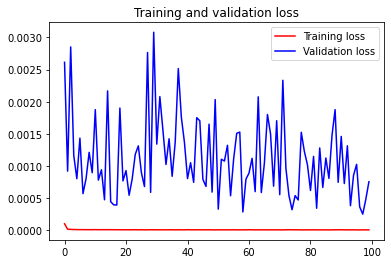

<Figure size 432x288 with 0 Axes>

In [46]:
### plot a graph for training and validation loss to visualize the results of model training

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.figure()


plt.show()

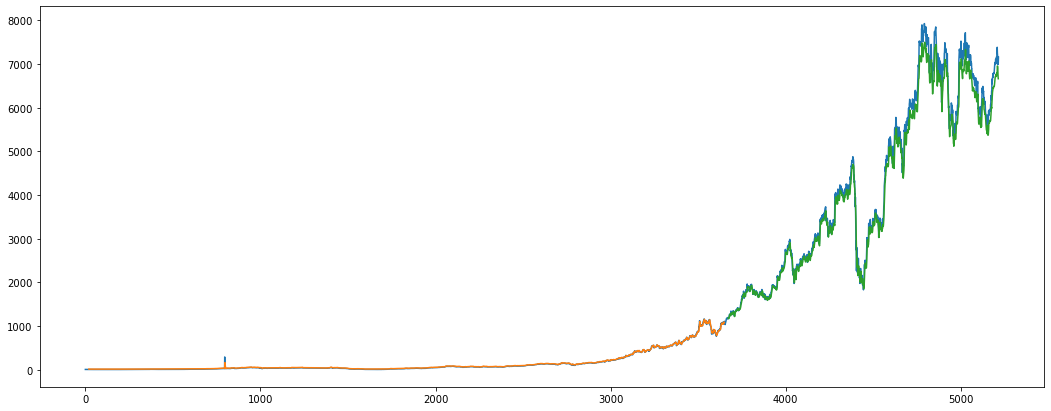

In [47]:
# shift train predictions for plotting
look_back=20
trainPredictPlot = numpy.empty_like(df1)  ## to take same shape and sata type of df1
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt1 = plt.figure(figsize=(18,7))
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [48]:
ytest

array([0.14851116, 0.14725567, 0.14859948, ..., 0.88143571, 0.88257767,
       0.88517063])

In [49]:
test_predict

array([[1180.9781],
       [1178.4799],
       [1171.7285],
       ...,
       [6799.6655],
       [6707.7856],
       [6665.687 ]], dtype=float32)

In [50]:
test_predict1 = test_predict.flatten()

In [51]:
len(ytest)

1544

In [52]:
test_predict1

array([1180.9781, 1178.4799, 1171.7285, ..., 6799.6655, 6707.7856,
       6665.687 ], dtype=float32)

In [53]:
ytest1 = ytest.flatten()

In [54]:
ytest1 = ytest1.reshape(1,-1)

In [55]:
ytest1

array([[0.14851116, 0.14725567, 0.14859948, ..., 0.88143571, 0.88257767,
        0.88517063]])

In [56]:
ytest2 = scaler.inverse_transform(ytest1)

In [57]:
ytest2

array([[1181.05004883, 1171.09997559, 1181.75      , ..., 6989.64990234,
        6998.70019531, 7019.25      ]])

In [58]:
ytest2 = ytest2.flatten()

In [59]:
len(ytest2)

1544

In [64]:
df2 = df.iloc[3672:,:]

In [65]:
len(df2)

1544

In [66]:
df2.head()

,Open,Close
Date,,
2017-03-31,1188.000000,1171.099976
2017-04-03,1170.050049,1181.750000
2017-04-05,1190.000000,1173.099976
2017-04-06,1177.800049,1198.099976
2017-04-07,1198.000000,1201.599976


In [67]:
df2['predicted'] = test_predict1

In [68]:
df2.head(20)

,Open,Close,predicted
Date,,,
2017-03-31,1188.000000,1171.099976,1180.978149
2017-04-03,1170.050049,1181.750000,1178.479858
2017-04-05,1190.000000,1173.099976,1171.728516
2017-04-06,1177.800049,1198.099976,1172.371094
2017-04-07,1198.000000,1201.599976,1169.399170
2017-04-10,1201.699951,1240.750000,1179.792725
2017-04-11,1246.000000,1255.949951,1189.185669
2017-04-12,1260.000000,1266.199951,1213.916626
2017-04-13,1267.800049,1273.900024,1237.148193


In [69]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1544 entries, 2017-03-31 to 2023-06-30
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1544 non-null   float64
 1   Close      1544 non-null   float64
 2   predicted  1544 non-null   float32
dtypes: float32(1), float64(2)
memory usage: 42.2 KB


In [70]:
df2.tail()

,Open,Close,predicted
Date,,,
2023-06-22,7200.100098,7030.000000,6952.465820
2023-06-23,7020.950195,6989.649902,6917.601562
2023-06-26,6990.000000,6998.700195,6799.665527
2023-06-27,7030.000000,7019.250000,6707.785645
2023-06-30,7100.000000,7160.600098,6665.687012


In [71]:
df2['temp_signal'] = df2['predicted'] - df2['Close']

In [72]:
df2.head()

,Open,Close,predicted,temp_signal
Date,,,,
2017-03-31,1188.000000,1171.099976,1180.978149,9.878174
2017-04-03,1170.050049,1181.750000,1178.479858,-3.270142
2017-04-05,1190.000000,1173.099976,1171.728516,-1.371460
2017-04-06,1177.800049,1198.099976,1172.371094,-25.728882
2017-04-07,1198.000000,1201.599976,1169.399170,-32.200806


In [73]:
df2['signal'] = df2['temp_signal'].apply(lambda x:1 if x>0 else 0)

In [74]:
df2.head()

,Open,Close,predicted,temp_signal,signal
Date,,,,,
2017-03-31,1188.000000,1171.099976,1180.978149,9.878174,1
2017-04-03,1170.050049,1181.750000,1178.479858,-3.270142,0
2017-04-05,1190.000000,1173.099976,1171.728516,-1.371460,0
2017-04-06,1177.800049,1198.099976,1172.371094,-25.728882,0
2017-04-07,1198.000000,1201.599976,1169.399170,-32.200806,0


In [75]:
df2.drop(columns='temp_signal',inplace = True)

In [76]:
df2.head()

,Open,Close,predicted,signal
Date,,,,
2017-03-31,1188.000000,1171.099976,1180.978149,1
2017-04-03,1170.050049,1181.750000,1178.479858,0
2017-04-05,1190.000000,1173.099976,1171.728516,0
2017-04-06,1177.800049,1198.099976,1172.371094,0
2017-04-07,1198.000000,1201.599976,1169.399170,0


In [77]:
signal = list(df2['signal'])

In [78]:
signal

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [79]:
signal.insert(0,999)

In [80]:
signal

[999,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0

In [81]:
len(df2)

1544

In [82]:
len(signal)

1545

In [83]:
signal.pop()

0

In [84]:
len(signal)

1544

In [85]:
new_signal = np.array(signal)

In [86]:
new_signal

array([999,   1,   0, ...,   0,   0,   0])

In [87]:
df2['new_signal'] = new_signal

In [88]:
df2.head()

,Open,Close,predicted,signal,new_signal
Date,,,,,
2017-03-31,1188.000000,1171.099976,1180.978149,1,999
2017-04-03,1170.050049,1181.750000,1178.479858,0,1
2017-04-05,1190.000000,1173.099976,1171.728516,0,0
2017-04-06,1177.800049,1198.099976,1172.371094,0,0
2017-04-07,1198.000000,1201.599976,1169.399170,0,0


In [89]:
df2.drop(columns = 'signal',inplace = True)

In [90]:
df3 = df2[df2['new_signal']==1]

In [91]:
df3.head()

,Open,Close,predicted,new_signal
Date,,,,
2017-04-03,1170.050049,1181.750000,1178.479858,1
2017-04-19,1237.800049,1242.949951,1265.528809,1
2017-04-20,1253.000000,1252.000000,1249.674805,1
2017-04-28,1278.050049,1276.199951,1306.132690,1
2017-05-02,1281.900024,1268.599976,1299.078003,1


In [92]:
df3['profit_loss'] = df3['Close'] - df3['Open']

In [93]:
df3.head()

,Open,Close,predicted,new_signal,profit_loss
Date,,,,,
2017-04-03,1170.050049,1181.750000,1178.479858,1,11.699951
2017-04-19,1237.800049,1242.949951,1265.528809,1,5.149902
2017-04-20,1253.000000,1252.000000,1249.674805,1,-1.000000
2017-04-28,1278.050049,1276.199951,1306.132690,1,-1.850098
2017-05-02,1281.900024,1268.599976,1299.078003,1,-13.300049


In [94]:
df3['profit_loss'].sum()

115.0504150390625

In [95]:
df4 = df2[df2['new_signal']==0]

In [96]:
df4['profit_loss'] = df4['Open'] - df4['Close']

In [97]:
df4.head()

,Open,Close,predicted,new_signal,profit_loss
Date,,,,,
2017-04-05,1190.000000,1173.099976,1171.728516,0,16.900024
2017-04-06,1177.800049,1198.099976,1172.371094,0,-20.299927
2017-04-07,1198.000000,1201.599976,1169.399170,0,-3.599976
2017-04-10,1201.699951,1240.750000,1179.792725,0,-39.050049
2017-04-11,1246.000000,1255.949951,1189.185669,0,-9.949951


In [98]:
df2.head()

,Open,Close,predicted,new_signal
Date,,,,
2017-03-31,1188.000000,1171.099976,1180.978149,999
2017-04-03,1170.050049,1181.750000,1178.479858,1
2017-04-05,1190.000000,1173.099976,1171.728516,0
2017-04-06,1177.800049,1198.099976,1172.371094,0
2017-04-07,1198.000000,1201.599976,1169.399170,0


In [99]:
df2.tail()

,Open,Close,predicted,new_signal
Date,,,,
2023-06-22,7200.100098,7030.000000,6952.465820,0
2023-06-23,7020.950195,6989.649902,6917.601562,0
2023-06-26,6990.000000,6998.700195,6799.665527,0
2023-06-27,7030.000000,7019.250000,6707.785645,0
2023-06-30,7100.000000,7160.600098,6665.687012,0


In [100]:
df4['profit_loss'].sum()

5786.003662109375

In [101]:
Total_profit = df4['profit_loss'].sum() + df3['profit_loss'].sum()

In [102]:
Total_profit

5901.0540771484375

In [103]:
# check open price for first day and close price for last day
print("Starting price: ",df2.iloc[0][0])
print("Ending price: ", df2.iloc[-1][2])

Starting price:  1188.0
Ending price:  6665.68701171875


In [104]:
# total profit if buy and hold

buy_hold_profit = df2.iloc[-1][2] - df2.iloc[0][0]
buy_hold_profit

5477.68701171875

In [105]:
# excess profit generated by algo model

excess_profit = Total_profit - buy_hold_profit
excess_profit

423.3670654296875

In [106]:
# excess profit in percent

excess_profit_percent = (excess_profit *100)/Total_profit
excess_profit_percent

7.174431209996145

In [ ]:
len(df3)

In [ ]:
len(df4)

In [ ]:
len(df2)